*Filename* : Types of convolutions  
*Test Accuracy* : (73.24%%)  
*Train Accuracy* : (71.82%)  
*Total params* : 196,096

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/ERA_V2/session9/'
import model

/content/gdrive/MyDrive/ERA_V2/session9


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, ShiftScaleRotate, CoarseDropout

%matplotlib inline

In [4]:
class album_train():
    def __init__(self):
        self.albumentations_transform = Compose([
            ShiftScaleRotate(),
            HorizontalFlip(),
            CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
                          fill_value=[0.4914, 0.4822, 0.4471], mask_fill_value=None, always_apply=False, p=0.3),
            Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
            ToTensorV2()
        ])
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

class album_test():
    def __init__(self):
        self.albumentations_transform = Compose([
            Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
            ToTensorV2()
        ])

    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

In [5]:
train = datasets.CIFAR10('./Data',train=True, transform=album_train(), download=True)

test = datasets.CIFAR10('./Data',train=False, transform=album_test(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# Mean and STD calculation
data = train.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


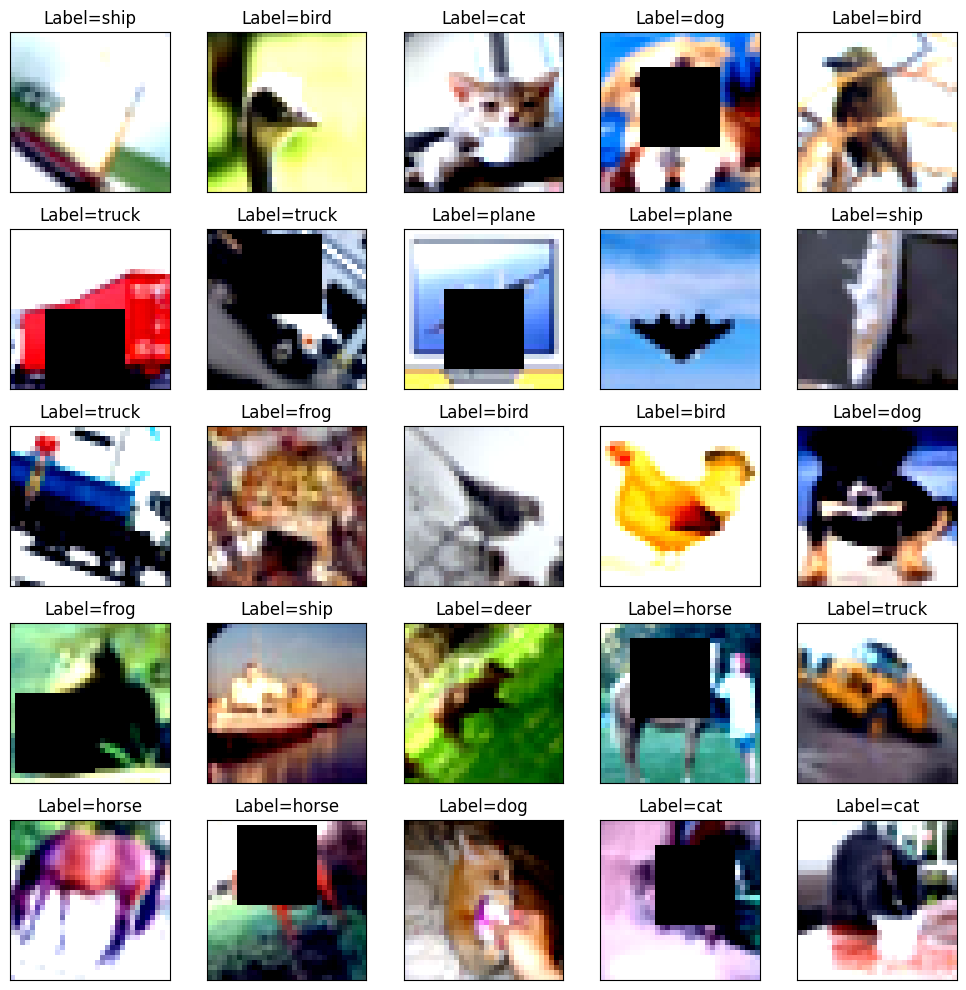

In [8]:
# get some random training images
images,labels = next(iter(train_loader))
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
sample_size=25

images = images[0:sample_size]
labels = labels[0:sample_size]

fig = plt.figure(figsize=(10, 10))

# Show images
for idx in np.arange(len(labels.numpy())):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    img = images[idx]/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    ax.imshow(img, cmap='gray')
    ax.set_title("Label={}".format(str(classes[labels[idx]])))

fig.tight_layout()
plt.show()

In [9]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_S9 = model.Model_S9().to(device)
summary(model_S9, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           3,456
              ReLU-2          [-1, 128, 28, 28]               0
       BatchNorm2d-3          [-1, 128, 28, 28]             256
           Dropout-4          [-1, 128, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           8,192
            Conv2d-6          [-1, 128, 24, 24]          73,728
              ReLU-7          [-1, 128, 24, 24]               0
       BatchNorm2d-8          [-1, 128, 24, 24]             256
           Dropout-9          [-1, 128, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]           8,192
           Conv2d-11          [-1, 256, 11, 11]           2,304
             ReLU-12          [-1, 256, 11, 11]               0
      BatchNorm2d-13          [-1, 256, 11, 11]             512
          Dropout-14          [-1,

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model_S9 = model.Model_S9().to(device)
optimizer = optim.SGD(model_S9.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_S9, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_S9, device, test_loader)

EPOCH: 0


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.5814013481140137 Batch_id=781 Accuracy=36.91: 100%|██████████| 782/782 [00:22<00:00, 34.18it/s]



Test set: Average loss: 1.3660, Accuracy: 5054/10000 (50.54%)

EPOCH: 1


Loss=1.5435718297958374 Batch_id=781 Accuracy=46.90: 100%|██████████| 782/782 [00:22<00:00, 35.52it/s]



Test set: Average loss: 1.1846, Accuracy: 5763/10000 (57.63%)

EPOCH: 2


Loss=1.4752254486083984 Batch_id=781 Accuracy=51.03: 100%|██████████| 782/782 [00:21<00:00, 36.40it/s]



Test set: Average loss: 1.0840, Accuracy: 6181/10000 (61.81%)

EPOCH: 3


Loss=1.5635230541229248 Batch_id=781 Accuracy=53.83: 100%|██████████| 782/782 [00:20<00:00, 38.70it/s]



Test set: Average loss: 1.0383, Accuracy: 6379/10000 (63.79%)

EPOCH: 4


Loss=1.0214426517486572 Batch_id=781 Accuracy=55.60: 100%|██████████| 782/782 [00:20<00:00, 37.32it/s]



Test set: Average loss: 0.9669, Accuracy: 6590/10000 (65.90%)

EPOCH: 5


Loss=1.489831805229187 Batch_id=781 Accuracy=56.78: 100%|██████████| 782/782 [00:19<00:00, 39.41it/s]



Test set: Average loss: 0.9284, Accuracy: 6784/10000 (67.84%)

EPOCH: 6


Loss=1.2784193754196167 Batch_id=781 Accuracy=58.44: 100%|██████████| 782/782 [00:21<00:00, 36.92it/s]



Test set: Average loss: 0.9181, Accuracy: 6794/10000 (67.94%)

EPOCH: 7


Loss=0.9391434788703918 Batch_id=781 Accuracy=61.91: 100%|██████████| 782/782 [00:19<00:00, 40.03it/s]



Test set: Average loss: 0.8215, Accuracy: 7194/10000 (71.94%)

EPOCH: 8


Loss=1.0108964443206787 Batch_id=781 Accuracy=63.00: 100%|██████████| 782/782 [00:20<00:00, 38.66it/s]



Test set: Average loss: 0.8085, Accuracy: 7240/10000 (72.40%)

EPOCH: 9


Loss=0.9913666844367981 Batch_id=781 Accuracy=62.89: 100%|██████████| 782/782 [00:20<00:00, 38.37it/s]



Test set: Average loss: 0.8063, Accuracy: 7214/10000 (72.14%)

EPOCH: 10


Loss=0.8878925442695618 Batch_id=781 Accuracy=63.27: 100%|██████████| 782/782 [00:21<00:00, 36.88it/s]



Test set: Average loss: 0.8007, Accuracy: 7236/10000 (72.36%)

EPOCH: 11


Loss=1.130533218383789 Batch_id=781 Accuracy=63.63: 100%|██████████| 782/782 [00:20<00:00, 37.25it/s]



Test set: Average loss: 0.7911, Accuracy: 7277/10000 (72.77%)

EPOCH: 12


Loss=0.8017400503158569 Batch_id=781 Accuracy=64.31: 100%|██████████| 782/782 [00:20<00:00, 38.68it/s]



Test set: Average loss: 0.7888, Accuracy: 7271/10000 (72.71%)

EPOCH: 13


Loss=1.2983466386795044 Batch_id=781 Accuracy=64.09: 100%|██████████| 782/782 [00:20<00:00, 38.43it/s]



Test set: Average loss: 0.7813, Accuracy: 7287/10000 (72.87%)

EPOCH: 14


Loss=1.3611500263214111 Batch_id=781 Accuracy=64.60: 100%|██████████| 782/782 [00:20<00:00, 38.93it/s]



Test set: Average loss: 0.7790, Accuracy: 7324/10000 (73.24%)

EPOCH: 15


Loss=0.660031259059906 Batch_id=781 Accuracy=64.79: 100%|██████████| 782/782 [00:19<00:00, 39.11it/s]



Test set: Average loss: 0.7719, Accuracy: 7345/10000 (73.45%)

EPOCH: 16


Loss=1.439635992050171 Batch_id=781 Accuracy=64.80: 100%|██████████| 782/782 [00:21<00:00, 36.95it/s]



Test set: Average loss: 0.7711, Accuracy: 7331/10000 (73.31%)

EPOCH: 17


Loss=0.8540055155754089 Batch_id=781 Accuracy=64.49: 100%|██████████| 782/782 [00:19<00:00, 39.85it/s]



Test set: Average loss: 0.7741, Accuracy: 7356/10000 (73.56%)

EPOCH: 18


Loss=1.1207618713378906 Batch_id=781 Accuracy=64.59: 100%|██████████| 782/782 [00:22<00:00, 34.49it/s]



Test set: Average loss: 0.7736, Accuracy: 7327/10000 (73.27%)

EPOCH: 19


Loss=0.7861871719360352 Batch_id=781 Accuracy=65.03: 100%|██████████| 782/782 [00:19<00:00, 39.23it/s]



Test set: Average loss: 0.7705, Accuracy: 7339/10000 (73.39%)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


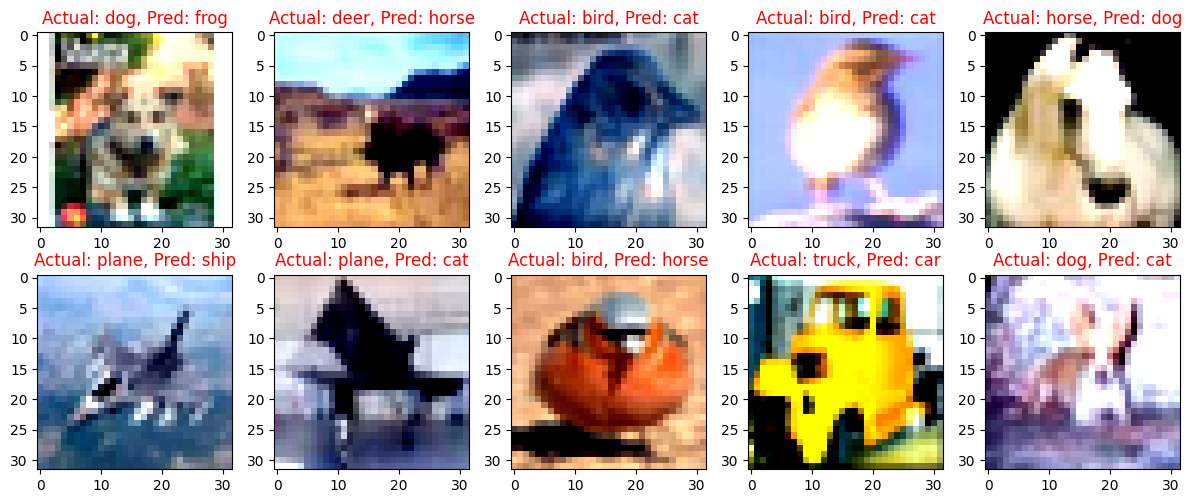

In [13]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model_S9.eval()

misclassified_images = []
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_S9(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                actual_labels.append(classes[target[i]])
                predicted_labels.append(classes[pred[i]])

# Plot the misclassified images
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i+1)
    img = misclassified_images[i].cpu()
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

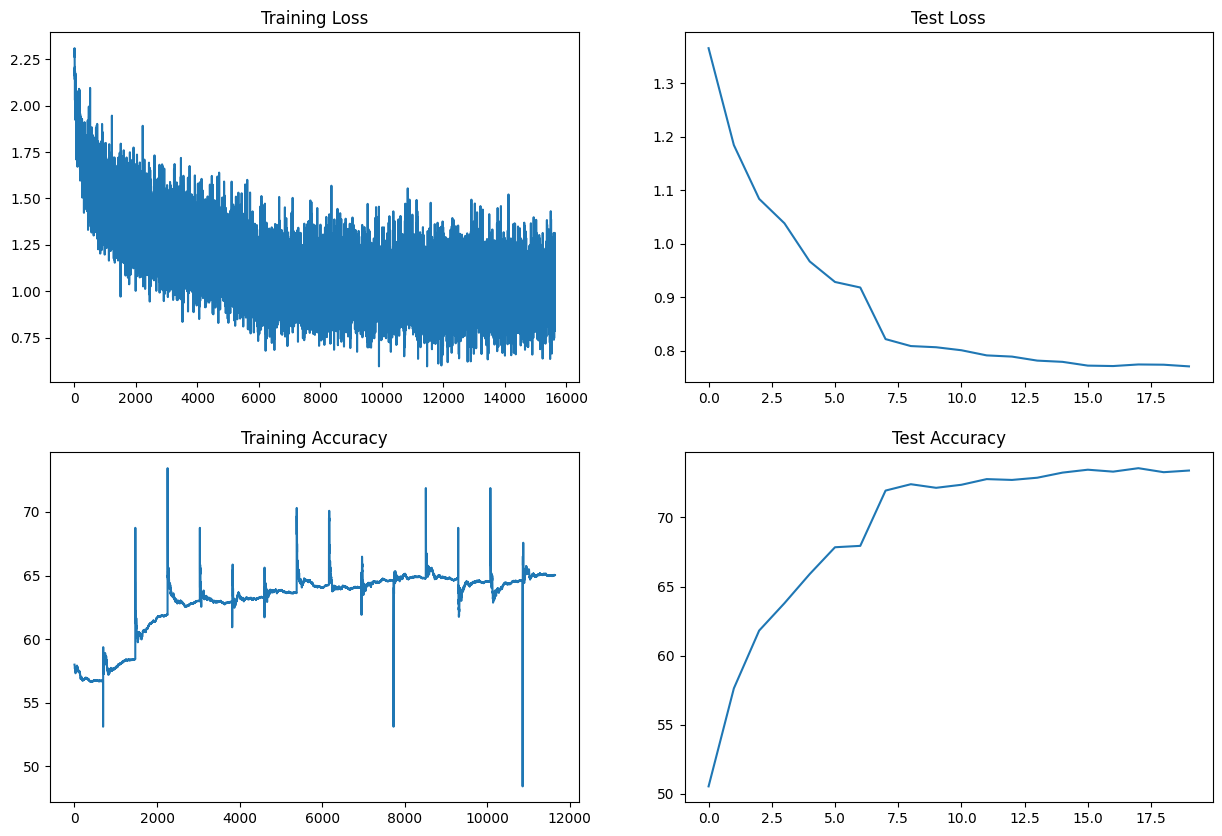

In [14]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")